# NLST Demographic Info

Handle the demographic information columns (there's so many) before examining performance.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import json

from utilities.info import *

FILE_DIR = f"{TEAMS_DIR}/files"
DICT_PATH = f"{FILE_DIR}/participant_d040722.csv"

## Load Demographic Info and Choose Rows Based on Patients

Kiran data. Our main dataset, including validation predictions.

In [ ]:
PREDS_PATH = f"{FILE_DIR}/nlst_allmodels.csv"
INCLUDES_KIRAN_DATA = True

OUTDEMOS_PATH = f"{FILE_DIR}/nlst_demos.csv"
OUTMERGE_PATH = f"{FILE_DIR}/nlst_allmodels_demos.csv"
OUTCOLS_PATH = f"{FILE_DIR}/nlst_democols.json"

Sybil training data splits. For prevalence checks.

In [ ]:
# PREDS_PATH = f"{FILE_DIR}/sybil-nlst-splitinfo.csv"
# INCLUDES_KIRAN_DATA = False

# OUTDEMOS_PATH = f"{FILE_DIR}/nlst_sybil_demos_patientlevel.csv"
# OUTMERGE_PATH = f"{FILE_DIR}/nlst_sybil_demos.csv"
# OUTCOLS_PATH = f"{FILE_DIR}/nlst_sybil_democols.json"

In [337]:
nlst_preds = pd.read_csv(PREDS_PATH)
nlst_preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41280 entries, 0 to 41279
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 41280 non-null  object
 1   split              41280 non-null  object
 2   PatientID          41280 non-null  int64 
 3   timepoint          41280 non-null  int64 
 4   SeriesInstanceUID  41280 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.6+ MB


In [338]:
nlst_dict_full = pd.read_csv(DICT_PATH)
nlst_dict_full.info()

C:\Users\shaur\AppData\Local\Temp\ipykernel_8472\3010214097.py:1: DtypeWarning: Columns (239,240,348) have mixed types. Specify dtype option on import or set low_memory=False.
  nlst_dict_full = pd.read_csv(DICT_PATH)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53452 entries, 0 to 53451
Columns: 356 entries, cen to evpsent
dtypes: float64(283), int64(64), object(9)
memory usage: 145.2+ MB


In [339]:
df = nlst_dict_full[nlst_dict_full['pid'].isin(nlst_preds['PatientID'])].reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14185 entries, 0 to 14184
Columns: 356 entries, cen to evpsent
dtypes: float64(283), int64(64), object(9)
memory usage: 38.5+ MB


## Choose Demographic Columns

In [340]:
cols = {"num": {}, 'cat': {}}
df['PatientID'] = df['pid']
cols["info"] = ['PatientID', 'study']
df['study'].value_counts(dropna=False)

study
1    9841
2    2721
3    1623
Name: count, dtype: int64

Next up we analyze and aggregate the columns since that still leaves us about 140 at the end.

### Demographic columns

In [341]:
col_demo_cat = ['race', 'gender', 'ethnic', 'marital', 'educat']
col_demo_num = ['age', 'height', 'weight']
df[col_demo_cat + col_demo_num].isna().sum()

race        0
gender      0
ethnic      0
marital     0
educat      0
age         0
height     20
weight     36
dtype: int64

In [342]:
print(df['educat'].value_counts(dropna=False))
df['educat'].replace([8, 95, 98, 99], value=np.nan, inplace=True)
print(df['educat'].value_counts(dropna=False))

educat
3     3397
5     3284
6     2403
7     2027
4     1990
2      629
8      251
1      187
99      17
Name: count, dtype: int64
educat
3.0    3397
5.0    3284
6.0    2403
7.0    2027
4.0    1990
2.0     629
NaN     268
1.0     187
Name: count, dtype: int64


C:\Users\shaur\AppData\Local\Temp\ipykernel_8472\394257443.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['educat'].replace([8, 95, 98, 99], value=np.nan, inplace=True)


In [343]:
print(df['ethnic'].value_counts(dropna=False))
df['ethnic'].replace([7, 95, 98, 99], value=np.nan, inplace=True)
print(df['ethnic'].value_counts(dropna=False))

ethnic
2     13872
1       250
99       59
7         4
Name: count, dtype: int64
ethnic
2.0    13872
1.0      250
NaN       63
Name: count, dtype: int64


C:\Users\shaur\AppData\Local\Temp\ipykernel_8472\1743828899.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ethnic'].replace([7, 95, 98, 99], value=np.nan, inplace=True)


In [344]:
print(df['marital'].value_counts(dropna=False))
df['marital'].replace([7, 9], value=np.nan, inplace=True)
print(df['marital'].value_counts(dropna=False))

marital
2.0    9673
5.0    2659
3.0    1047
1.0     621
4.0     150
9.0      23
7.0      12
Name: count, dtype: int64
marital
2.0    9673
5.0    2659
3.0    1047
1.0     621
4.0     150
NaN      35
Name: count, dtype: int64


C:\Users\shaur\AppData\Local\Temp\ipykernel_8472\1313743828.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['marital'].replace([7, 9], value=np.nan, inplace=True)


In [345]:
print(df['race'].value_counts(dropna=False))
df['race'].replace([7, 95, 96, 98, 99], value=np.nan, inplace=True)
print(df['race'].value_counts(dropna=False))

race
1     13030
2       518
3       304
6       193
5        47
4        44
7        30
99       15
98        2
96        2
Name: count, dtype: int64
race
1.0    13030
2.0      518
3.0      304
6.0      193
NaN       49
5.0       47
4.0       44
Name: count, dtype: int64


C:\Users\shaur\AppData\Local\Temp\ipykernel_8472\2770304117.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['race'].replace([7, 95, 96, 98, 99], value=np.nan, inplace=True)


In [346]:
df.query('ethnic == 1')['race'].value_counts(dropna=False)

race
1.0    177
NaN     35
6.0     19
3.0      6
2.0      5
4.0      5
5.0      3
Name: count, dtype: int64

In [347]:
df['NonHispanicWhite'] = (df['race'] == 1.0) & (df['ethnic'] == 2.0)
col_demo_cat.append('NonHispanicWhite')
df['NonHispanicWhite'].value_counts(dropna=False)

NonHispanicWhite
True     12808
False     1377
Name: count, dtype: int64

In [348]:
df['HighSchoolPlus'] = (df['educat'] != 1.0)
col_demo_cat.append('HighSchoolPlus')
df['HighSchoolPlus'].value_counts(dropna=False)

HighSchoolPlus
True     13998
False      187
Name: count, dtype: int64

In [349]:
df['Married'] = (df['marital'] == 2.0)
col_demo_cat.append('Married')
df['Married'].value_counts(dropna=False)

Married
True     9673
False    4512
Name: count, dtype: int64

In [350]:
def bmi_calc(height, weight):
    return (weight * 703) / (height * height)

df['BMI'] = bmi_calc(height=df['height'], weight=df['weight'])
col_demo_num.append('BMI')
df['BMI'].describe()

count    14138.000000
mean        27.860137
std          5.002908
min         14.143195
25%         24.404880
50%         27.213884
75%         30.606289
max         65.000416
Name: BMI, dtype: float64

In [351]:
df['WhiteOrBlack'] = df['race'].replace([3, 4, 5, 6], value=np.nan, inplace=False)
col_demo_cat.append('WhiteOrBlack')
df['WhiteOrBlack'].value_counts()

WhiteOrBlack
1.0    13030
2.0      518
Name: count, dtype: int64

In [352]:
df['Overweight'] = (df['BMI'] >= 25)
col_demo_cat.append('Overweight')

In [353]:
df['Unfinished_ed'] = (df['educat'] == 2) | (df['educat'] == 5)
col_demo_cat.append('Unfinished_ed')

In [354]:
df[col_demo_cat + col_demo_num].isna().sum()

race                 49
gender                0
ethnic               63
marital              35
educat              268
NonHispanicWhite      0
HighSchoolPlus        0
Married               0
WhiteOrBlack        637
Overweight            0
Unfinished_ed         0
age                   0
height               20
weight               36
BMI                  47
dtype: int64

Age and gender are already included in Kiran's sheet so we don't need it here as well.

In [355]:
cols['cat']['demo'] = list(set(col_demo_cat) - set(['gender']))
cols['num']['demo'] = list(set(col_demo_num) - set(['age']))

In [356]:
cols

{'num': {'demo': ['weight', 'height', 'BMI']},
 'cat': {'demo': ['Overweight',
   'race',
   'ethnic',
   'Unfinished_ed',
   'educat',
   'NonHispanicWhite',
   'WhiteOrBlack',
   'marital',
   'Married',
   'HighSchoolPlus']},
 'info': ['PatientID', 'study']}

### Smoking columns

In [357]:
col_smoke_cat =  ['cigar', 'cigsmok', 'pipe', 'smokelive', 'smokework']
col_smoke_num = ['pkyr', 'smokeage', 'smokeday', 'smokeyr']
df[col_smoke_cat + col_smoke_num].isna().sum()

cigar        38
cigsmok       0
pipe         79
smokelive    50
smokework    83
pkyr          0
smokeage      0
smokeday      0
smokeyr       0
dtype: int64

Let's not include `age_quit` - too many None values.

In [358]:
pd.DataFrame({c: df[c].value_counts(dropna=False) for c in col_smoke_cat}).drop_duplicates()

,cigar,cigsmok,pipe,smokelive,smokework
0.0,11134,7406.0,10828,1754,1972
1.0,3013,6779.0,3278,12381,12130
NaN,38,NaN,79,50,83


In [359]:
pd.DataFrame({c: [len(df.query(f'gender == {i} and {c} == 1')) for i in [1,2]] for c in col_smoke_cat}, index=['M','F'])

,cigar,cigsmok,pipe,smokelive,smokework
M,2760,3885,3159,6999,7382
F,253,2894,119,5382,4748


In [360]:
cols['cat']['smoke'] = col_smoke_cat
cols['num']['smoke'] = col_smoke_num

### Work history columns

In [361]:
workfacets = ['res', 'wrk', 'yrs']
worktypes = ['asbe', 'baki', 'butc', 'chem', 'coal', 'cott', 'farm', 'fire', 'flou', 'foun', 'hard', 'pain', 'sand', 'weld']
workcols = {f: [f+t for t in worktypes] for f in workfacets}

In [362]:
for t in worktypes:
    hasworked = len(df.query(f'wrk{t} == 1'))
    resnotnull = len(df[~df[f'res{t}'].isna()])
    yrsnotnull = len(df[~df[f'yrs{t}'].isna()])
    print(t, hasworked, resnotnull, yrsnotnull)

asbe 664 644 626
baki 316 308 307
butc 286 277 283
chem 842 802 819
coal 84 82 83
cott 104 100 102
farm 1583 1523 1542
fire 273 264 267
flou 148 139 141
foun 618 596 603
hard 107 105 107
pain 700 672 671
sand 234 217 210
weld 829 798 798


In [363]:
df[workcols['wrk']].sum(axis=1).sort_values(ascending=False)

9597     12.0
3256     12.0
7846      9.0
8734      8.0
10619     8.0
         ... 
18        0.0
17        0.0
16        0.0
15        0.0
14        0.0
Length: 14185, dtype: float64

In [364]:
pd.DataFrame({t: df[f'wrk{t}'].value_counts(dropna=False) for t in worktypes})

,asbe,baki,butc,chem,coal,cott,farm,fire,flou,foun,hard,pain,sand,weld
0.0,13506,13866,13896,13336,14098,14076,12595,13908,14034,13561,14075,13482,13948,13353
1.0,664,316,286,842,84,104,1583,273,148,618,107,700,234,829
NaN,15,3,3,7,3,5,7,4,3,6,3,3,3,3


In [365]:
pd.DataFrame({t: [len(df.query(f'gender == {i} and wrk{t} == 1')) for i in [1,2]] for t in worktypes}, index=['M','F'])

,asbe,baki,butc,chem,coal,cott,farm,fire,flou,foun,hard,pain,sand,weld
M,629,179,241,590,81,68,1261,266,135,574,105,588,217,791
F,35,137,45,252,3,36,322,7,13,44,2,112,17,38


In [366]:
pd.DataFrame({t: df[f'res{t}'].value_counts(dropna=False) for t in worktypes}).drop_duplicates()

,asbe,baki,butc,chem,coal,cott,farm,fire,flou,foun,hard,pain,sand,weld
0.0,537,306.0,276.0,670,74,97.0,1472,123,122,517,90.0,481,106,656
1.0,92,2.0,1.0,114,6,3.0,39,133,15,72,15.0,181,107,137
2.0,15,NaN,NaN,18,2,NaN,12,8,2,7,NaN,10,4,5
NaN,13541,13877.0,13908.0,13383,14103,14085.0,12662,13921,14046,13589,14080.0,13513,13968,13387


In [367]:
for t in worktypes:
    nomask = df[f'res{t}'] == 0
    df[f'wrknomask{t}'] = nomask

df['wrknomask'] = df[[f'wrknomask{t}' for t in worktypes]].any(axis=1)

In [368]:
pd.DataFrame({t: [len(df.query(f'gender == {i} and wrknomask{t} == 1')) for i in [1,2]] for t in worktypes}, index=['M','F'])

,asbe,baki,butc,chem,coal,cott,farm,fire,flou,foun,hard,pain,sand,weld
M,502,171,233,451,71,64,1170,120,111,478,89,386,96,627
F,35,135,43,219,3,33,302,3,11,39,1,95,10,29


In [369]:
df['wrknomask'].value_counts()

wrknomask
False    10670
True      3515
Name: count, dtype: int64

In [370]:
df[workcols['res']].iloc[3156]

resasbe    NaN
resbaki    NaN
resbutc    NaN
reschem    NaN
rescoal    NaN
rescott    NaN
resfarm    NaN
resfire    NaN
resflou    NaN
resfoun    0.0
reshard    NaN
respain    NaN
ressand    NaN
resweld    0.0
Name: 3156, dtype: float64

In [371]:
df[workcols['yrs']].describe()

,yrsasbe,yrsbaki,yrsbutc,yrschem,yrscoal,yrscott,yrsfarm,yrsfire,yrsflou,yrsfoun,yrshard,yrspain,yrssand,yrsweld
count,626.000000,307.000000,283.000000,819.000000,83.000000,102.000000,1542.000000,267.000000,141.000000,603.000000,107.000000,671.000000,210.000000,798.000000
mean,13.931310,7.257329,8.918728,13.416361,12.481928,8.274510,14.367056,15.063670,10.269504,13.180763,10.168224,10.763040,9.885714,14.474937
std,12.645571,9.721728,11.505338,12.523768,12.735931,10.056432,11.964967,10.641089,12.264862,13.060382,11.313280,11.394901,10.509794,12.933136
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
25%,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,5.000000,5.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000
50%,10.000000,3.000000,4.000000,8.000000,8.000000,4.000000,10.000000,14.000000,4.000000,7.000000,5.000000,5.000000,5.000000,10.000000
75%,23.750000,8.000000,10.000000,23.500000,19.500000,10.000000,18.000000,25.000000,14.000000,23.000000,14.500000,15.000000,16.750000,25.000000
max,50.000000,60.000000,60.000000,50.000000,57.000000,43.000000,70.000000,40.000000,68.000000,47.000000,45.000000,50.000000,41.000000,50.000000


<Axes: >

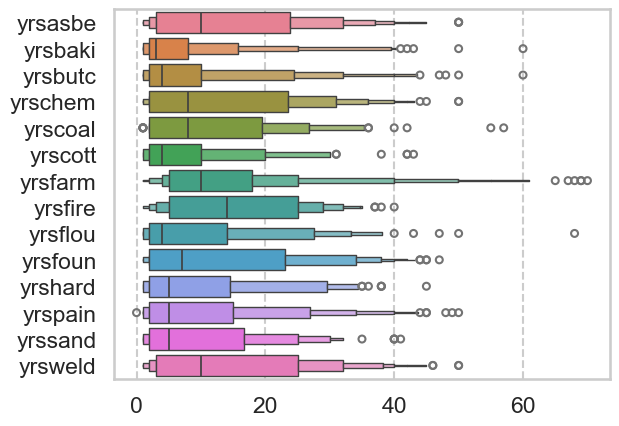

In [372]:
sns.boxenplot(data=df[workcols['yrs']], orient='h')

In [373]:
cols['cat']['work'] = workcols['wrk']

### Disease history columns

In [374]:
diseasefacets = ['age', 'diag']
diseasetypes = ['adas', 'asbe', 'bron', 'chas', 'chro', 'copd', 'diab', 'emph', 'fibr', 'hear', 'hype', 'pneu', 'sarc', 'sili', 'stro', 'tube']

In [375]:
pd.DataFrame({t: df[f'diag{t}'].value_counts(dropna=False) for t in diseasetypes}).drop_duplicates()

,adas,asbe,bron,chas,chro,copd,diab,emph,fibr,hear,hype,pneu,sarc,sili,stro,tube
0.0,13290,14007,13662,13680,12763,13391,12792,12982,14134,12299,9233,10961,14134,14138,13767,14018
1.0,880,163,480,495,1389,756,1383,1177,30,1846,4938,3204,25,21,405,155
NaN,15,15,43,10,33,38,10,26,21,40,14,20,26,26,13,12


In [376]:
pd.DataFrame({t: [len(df.query(f'gender == {i} and diag{t} == 1')) for i in [1,2]] for t in diseasetypes}, index=['M','F'])

,adas,asbe,bron,chas,chro,copd,diab,emph,fibr,hear,hype,pneu,sarc,sili,stro,tube
M,334,158,252,321,577,368,960,726,18,1395,2976,1592,12,19,251,89
F,546,5,228,174,812,388,423,451,12,451,1962,1612,13,2,154,66


In [377]:
df[[f"age{t}" for t in diseasetypes]].describe()

,ageadas,ageasbe,agebron,agechas,agechro,agecopd,agediab,ageemph,agefibr,agehear,agehype,agepneu,agesarc,agesili,agestro,agetube
count,843.000000,154.000000,416.000000,453.000000,1270.000000,710.000000,1348.000000,1111.000000,28.000000,1785.000000,4758.000000,2979.000000,24.000000,20.000000,393.000000,146.000000
mean,49.327402,54.785714,38.894231,6.682119,40.366929,56.352113,54.077893,55.974797,50.500000,53.620728,51.609079,34.274253,43.666667,56.600000,56.435115,27.705479
std,12.367571,8.498338,18.531338,3.751172,16.557063,7.744689,10.043662,8.783651,11.272714,10.415963,10.653711,19.732980,18.917824,11.513836,8.935225,18.357435
min,13.000000,14.000000,1.000000,0.000000,0.000000,16.000000,1.000000,16.000000,22.000000,1.000000,3.000000,0.000000,1.000000,18.000000,16.000000,0.000000
25%,43.000000,50.000000,25.000000,4.000000,30.000000,52.000000,50.000000,51.000000,48.000000,50.000000,45.000000,18.000000,29.250000,55.750000,52.000000,11.000000
50%,52.000000,56.000000,40.000000,6.000000,42.500000,56.000000,55.000000,57.000000,51.500000,55.000000,54.000000,35.000000,49.000000,59.500000,58.000000,26.000000
75%,58.000000,60.000000,54.250000,9.000000,54.000000,61.000000,60.000000,62.000000,59.000000,60.000000,59.000000,52.000000,58.750000,62.500000,62.000000,40.000000
max,72.000000,72.000000,73.000000,17.000000,73.000000,74.000000,73.000000,73.000000,66.000000,74.000000,79.000000,74.000000,69.000000,67.000000,73.000000,69.000000


<Axes: >

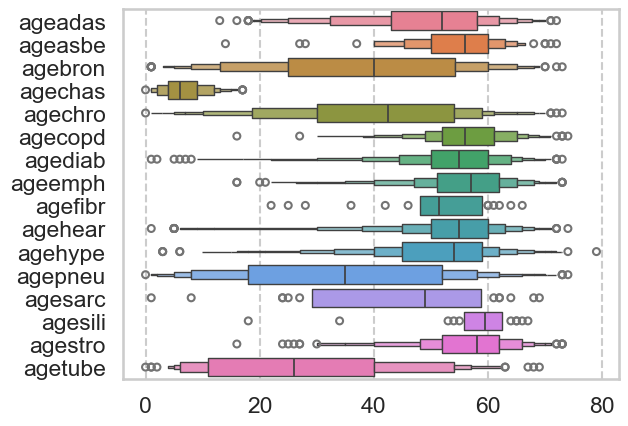

In [378]:
sns.boxenplot(data=df[[f"age{t}" for t in diseasetypes]], orient='h')

In [379]:
cols['cat']['disease'] = [f'diag{t}' for t in diseasetypes]

### Personal cancer history columns

In [380]:
pcancerfacets = ['age', 'canc']
pcancertypes = ['blad', 'brea', 'cerv', 'colo', 'esop', 'kidn', 'lary', 'lung', 'nasa', 'oral', 'panc', 'phar', 'stom', 'thyr', 'tran']

In [381]:
pd.DataFrame({t: df[f'canc{t}'].value_counts(dropna=False) for t in pcancertypes}).drop_duplicates()

,blad,brea,cerv,colo,esop,kidn,lary,lung,nasa,oral,panc,phar,stom,thyr,tran
0.0,14119,13986,13977,14125,14174,14162,14170,14171,14167,14152,14176,14175,14173,14152,14170
1.0,57,186,196,51,3,16,8,6,9,25,2,3,5,20,3
NaN,9,13,12,9,8,7,7,8,9,8,7,7,7,13,12


In [382]:
pd.DataFrame({t: [len(df.query(f'gender == {i} and canc{t} == 1')) for i in [1,2]] for t in pcancertypes}, index=['M','F'])

,blad,brea,cerv,colo,esop,kidn,lary,lung,nasa,oral,panc,phar,stom,thyr,tran
M,48,2,0,35,2,11,7,5,7,19,2,2,5,10,0
F,9,184,196,16,1,5,1,1,2,6,0,1,0,10,3


In [383]:
df[[f"age{t}" for t in pcancertypes]].describe()

,ageblad,agebrea,agecerv,agecolo,ageesop,agekidn,agelary,agelung,agenasa,ageoral,agepanc,agephar,agestom,agethyr,agetran
count,57.000000,183.000000,195.000000,49.000000,3.000000,16.000000,8.000000,6.000000,9.000000,25.00000,2.000000,3.000000,5.000000,20.000000,3.000000
mean,53.982456,51.049180,34.928205,53.346939,50.666667,55.312500,58.625000,59.166667,61.666667,53.64000,59.000000,52.000000,45.400000,39.950000,53.666667
std,10.447985,7.899283,9.596229,7.827705,7.371115,7.068416,5.730557,9.641922,7.211103,8.86416,4.242641,3.464102,7.127412,12.193506,8.504901
min,17.000000,25.000000,19.000000,32.000000,45.000000,46.000000,50.000000,45.000000,51.000000,35.00000,56.000000,48.000000,35.000000,22.000000,45.000000
25%,51.000000,46.000000,28.000000,48.000000,46.500000,50.000000,54.750000,53.500000,55.000000,49.00000,57.500000,51.000000,45.000000,32.500000,49.500000
50%,54.000000,52.000000,32.000000,55.000000,48.000000,52.500000,58.500000,60.000000,63.000000,53.00000,59.000000,54.000000,45.000000,35.000000,54.000000
75%,62.000000,57.000000,40.000000,59.000000,53.500000,59.500000,62.000000,67.250000,67.000000,60.00000,60.500000,54.000000,47.000000,45.250000,58.000000
max,68.000000,68.000000,64.000000,66.000000,59.000000,69.000000,67.000000,69.000000,72.000000,70.00000,62.000000,54.000000,55.000000,61.000000,62.000000


<Axes: >

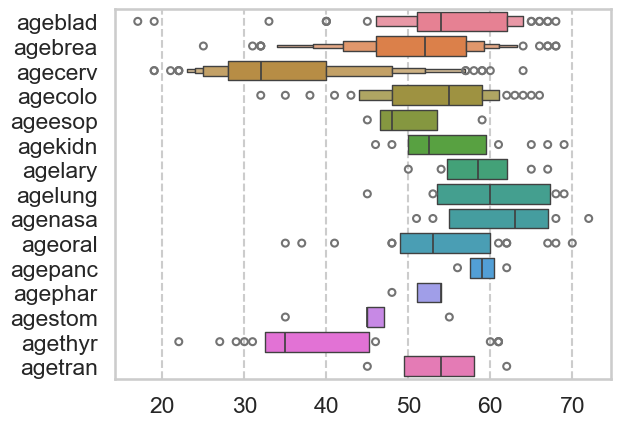

In [384]:
sns.boxenplot(data=df[[f"age{t}" for t in pcancertypes]], orient='h')

In [385]:
cols['cat']['canchist'] = [f"canc{t}" for t in pcancertypes]

In [386]:
df['PersonalCancerHist'] = df[[f"canc{t}" for t in pcancertypes]].any(axis=1)
df['PersonalCancerHist'].value_counts(dropna=False)

PersonalCancerHist
False    13622
True       563
Name: count, dtype: int64

### Family history Lung cancer columns
Unused because it doesn't match with existing `FamilyHistoryLungCa` column.

In [387]:
relatives = ['brother', 'sister', 'child', 'father', 'mother']
col_famhist = ['fam'+member for member in relatives]
pd.DataFrame({t: df[f'fam{t}'].value_counts(dropna=False) for t in relatives}).drop_duplicates()

,brother,sister,child,father,mother
0.0,13147,13308,13819,12340,12947
1.0,700,545,52,1460,940
NaN,338,332,314,385,298


In [388]:
df['famhist'] = df[col_famhist].any(axis=1)
df_famhist = df[['pid', 'famhist']].set_index('pid')
df_famhist.value_counts(dropna=False)

famhist
False      11058
True        3127
Name: count, dtype: int64

### Alcohol columns - UNUSED

In [389]:
alcohol_acrin = ['acrin_alc_curr', 'acrin_alc_ever', 'acrin_drink24hr', 'acrin_drinknum_curr', 'acrin_drinknum_form', 'acrin_drinkyrs_curr', 'acrin_drinkyrs_form', 'acrin_lastdrink']
alcohol_lss = ['lss_alcohol_freq', 'lss_alcohol_num']

In [390]:
df['study'].value_counts() #1 is LSS, 2 and 3 are ACRIN

study
1    9841
2    2721
3    1623
Name: count, dtype: int64

In [391]:
df['acrin_alc_curr'].value_counts(dropna=False)

acrin_alc_curr
NaN    10081
2.0     3001
1.0     1103
Name: count, dtype: int64

In [392]:
df['lss_alcohol_freq'].value_counts(dropna=False)

lss_alcohol_freq
NaN    4376
2.0    2465
5.0    2190
1.0    1979
3.0    1777
4.0    1398
Name: count, dtype: int64

In [393]:
df[alcohol_acrin + alcohol_lss].describe()

,acrin_alc_curr,acrin_alc_ever,acrin_drink24hr,acrin_drinknum_curr,acrin_drinknum_form,acrin_drinkyrs_curr,acrin_drinkyrs_form,acrin_lastdrink,lss_alcohol_freq,lss_alcohol_num
count,4104.000000,4335.000000,2911.000000,2908.000000,1017.000000,2895.000000,1025.000000,1098.000000,9809.000000,7752.000000
mean,1.731238,1.948097,0.984541,6.732118,14.094395,39.076684,24.993171,2.346084,2.934244,1.906992
std,0.443370,0.221857,1.695791,8.766636,20.099333,9.817565,13.565342,0.874269,1.445608,0.899400
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,1.000000,2.000000,0.000000,0.000000,0.000000,35.000000,15.000000,1.000000,2.000000,1.000000
50%,2.000000,2.000000,0.000000,4.000000,6.000000,40.000000,25.000000,3.000000,3.000000,2.000000
75%,2.000000,2.000000,2.000000,10.000000,20.000000,45.000000,35.000000,3.000000,4.000000,2.000000
max,2.000000,2.000000,30.000000,89.000000,200.000000,63.000000,70.000000,3.000000,5.000000,5.000000


I don't know how to aggregate these columns, if I'm gonna be honest.

### Lung Cancer columns

In [394]:
histology_cat_key = {
    1: "Small_cell_carcinoma",
    2: "Squamous_cell_carcinoma",
    3: "Adenocarcinoma",
    4: "Bronchiolo-alveolar_carcinoma",
    5: "Large_cell_carcinoma",
    6: "Adenosquamous_carcinoma",
    7: "Pleomorphic/sarcomatoid",
    8: "Carcinoid_tumor",
    9: "Unclassified_carcinoma",
}

In [395]:
df['LC_type'] = df['histology_cat'].replace(histology_cat_key)
df = pd.get_dummies(df, columns=['LC_type'], prefix='', prefix_sep='')

In [396]:
df['LC_stage'] = df['de_stag_7thed'].replace([999], value=np.nan, inplace=False)

In [397]:
cols['cat']['lungcanc'] = list(histology_cat_key.values()) + ['LC_stage']
cols['cat']['lungcanc'].remove("Pleomorphic/sarcomatoid")

### Other columns

In [398]:
if not INCLUDES_KIRAN_DATA:
    cols['cat']['other'] = ['wrknomask', 'PersonalCancerHist', 'FamilyHistoryLungCa']

    df['Gender'] = df['gender']
    cols['cat']['demo'].append('Gender')
    
    df['Age'] = df['age']
    cols['num']['demo'].append('Age')

    df['FamilyHistoryLungCa'] = df['famhist']

else:
    cols['cat']['other'] = ['wrknomask', 'PersonalCancerHist']

## Save Columns

In [399]:
cols

{'num': {'demo': ['weight', 'height', 'BMI', 'Age'],
  'smoke': ['pkyr', 'smokeage', 'smokeday', 'smokeyr']},
 'cat': {'demo': ['Overweight',
   'race',
   'ethnic',
   'Unfinished_ed',
   'educat',
   'NonHispanicWhite',
   'WhiteOrBlack',
   'marital',
   'Married',
   'HighSchoolPlus',
   'Gender'],
  'smoke': ['cigar', 'cigsmok', 'pipe', 'smokelive', 'smokework'],
  'work': ['wrkasbe',
   'wrkbaki',
   'wrkbutc',
   'wrkchem',
   'wrkcoal',
   'wrkcott',
   'wrkfarm',
   'wrkfire',
   'wrkflou',
   'wrkfoun',
   'wrkhard',
   'wrkpain',
   'wrksand',
   'wrkweld'],
  'disease': ['diagadas',
   'diagasbe',
   'diagbron',
   'diagchas',
   'diagchro',
   'diagcopd',
   'diagdiab',
   'diagemph',
   'diagfibr',
   'diaghear',
   'diaghype',
   'diagpneu',
   'diagsarc',
   'diagsili',
   'diagstro',
   'diagtube'],
  'canchist': ['cancblad',
   'cancbrea',
   'canccerv',
   'canccolo',
   'cancesop',
   'canckidn',
   'canclary',
   'canclung',
   'cancnasa',
   'cancoral',
   'cancpa

In [400]:
cols_num = sum(cols['num'].values(), start=[])
cols_cat = sum(cols['cat'].values(), start=[])
cols_list = cols_num + cols_cat + cols['info']
len(cols_list)

83

In [401]:
if INCLUDES_KIRAN_DATA:
    cols['cat']['demo'].append('Gender')
    cols['num']['demo'].append('Age')
    cols['cat']['other'] = ['wrknomask', 'PersonalCancerHist', 'FamilyHistoryLungCa', 'Emphysema']
    cols['cat']['nodule'] = ['Solid', 'GroundGlassOpacity', 'Perifissural', 'NonSolid',
       'PartSolid', 'SemiSolid', 'Calcified', 'NoduleInUpperLung', 'Spiculation']
    cols['num']['nodule'] = ["CoordX", "CoordY", "CoordZ"]
    cols['num']['other'] = ['Diameter_mm', 'NoduleCounts']

In [402]:
with open(OUTCOLS_PATH, 'w') as f:
    json.dump(cols, f)

In [403]:
df[cols_list].to_csv(OUTDEMOS_PATH, index=False)

In [404]:
nlst_preds_demos = nlst_preds.merge(df[cols_list], on='PatientID', how='left')
nlst_preds_demos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41280 entries, 0 to 41279
Data columns (total 87 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             41280 non-null  object 
 1   split                          41280 non-null  object 
 2   PatientID                      41280 non-null  int64  
 3   timepoint                      41280 non-null  int64  
 4   SeriesInstanceUID              41280 non-null  object 
 5   weight                         41175 non-null  float64
 6   height                         41222 non-null  float64
 7   BMI                            41144 non-null  float64
 8   Age                            41280 non-null  int64  
 9   pkyr                           41280 non-null  float64
 10  smokeage                       41280 non-null  float64
 11  smokeday                       41280 non-null  int64  
 12  smokeyr                        41280 non-null 

In [405]:
nlst_preds_demos

,id,split,PatientID,timepoint,SeriesInstanceUID,weight,height,BMI,Age,pkyr,...,Bronchiolo-alveolar_carcinoma,Large_cell_carcinoma,Adenosquamous_carcinoma,Carcinoid_tumor,Unclassified_carcinoma,LC_stage,wrknomask,PersonalCancerHist,FamilyHistoryLungCa,study
0,PID-204631__TimePoint-0__Series-1.3.6.1.4.1.14...,train,204631,0,1.3.6.1.4.1.14519.5.2.1.7009.9004.186764828479...,187.0,74.0,24.006757,72,108.0,...,False,False,False,False,False,NaN,True,False,False,2
1,PID-204631__TimePoint-1__Series-1.3.6.1.4.1.14...,train,204631,1,1.3.6.1.4.1.14519.5.2.1.7009.9004.154974321095...,187.0,74.0,24.006757,72,108.0,...,False,False,False,False,False,NaN,True,False,False,2
2,PID-204631__TimePoint-2__Series-1.3.6.1.4.1.14...,train,204631,2,1.3.6.1.4.1.14519.5.2.1.7009.9004.181632252038...,187.0,74.0,24.006757,72,108.0,...,False,False,False,False,False,NaN,True,False,False,2
3,PID-126153__TimePoint-2__Series-1.2.840.113654...,train,126153,2,1.2.840.113654.2.55.43665829455927473870872470...,145.0,67.0,22.707730,58,70.2,...,False,False,False,False,False,NaN,False,False,True,1
4,PID-126153__TimePoint-1__Series-1.2.840.113654...,train,126153,1,1.2.840.113654.2.55.18862732764668567267836753...,145.0,67.0,22.707730,58,70.2,...,False,False,False,False,False,NaN,False,False,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41275,PID-133831__TimePoint-2__Series-1.2.840.113654...,test,133831,2,1.2.840.113654.2.55.26279217761753193890516762...,230.0,70.0,32.997959,61,114.0,...,False,False,False,False,False,NaN,False,False,False,1
41276,PID-133831__TimePoint-0__Series-1.2.840.113654...,test,133831,0,1.2.840.113654.2.55.23986337370551290634823184...,230.0,70.0,32.997959,61,114.0,...,False,False,False,False,False,NaN,False,False,False,1
41277,PID-116981__TimePoint-0__Series-1.2.840.113654...,test,116981,0,1.2.840.113654.2.55.16179604920107519147811774...,270.0,72.0,36.614583,63,70.0,...,False,False,False,False,False,NaN,False,False,False,1
41278,PID-116981__TimePoint-2__Series-1.2.840.113654...,test,116981,2,1.2.840.113654.2.55.59492406653704762882979549...,270.0,72.0,36.614583,63,70.0,...,False,False,False,False,False,NaN,False,False,False,1


In [406]:
nlst_preds_demos.to_csv(OUTMERGE_PATH, index=False)